#**Predicting Blood Pressure with LSTM Neural Networks: An Explainable AI Perspective**
**Advisor**: Marcos Medeiros Raimundo </br>
**Master's thesis**: João Victor Palhares Barbosa

In [1]:
#Installing the calplot package
!pip install calplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 9.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8119 sha256=5a1e75686ba46d8b5d53d1f0ad244068ea2d7877e4350fb8e9524698c9efecc4
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot


In [2]:
!python --version

Python 3.10.12


# Importing some packages

In [3]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError, CategoricalAccuracy
from keras.losses import MeanSquaredError
from keras.callbacks import ModelCheckpoint
from keras import Sequential
from keras.layers import LSTM, Dense
from keras.engine.input_layer import InputLayer
from tensorflow import keras

from statsmodels.tsa.seasonal import STL
from sklearn.metrics import mean_squared_error, mean_absolute_error


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import calplot

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

# Verifying the CPU versus GPU velocity

In [4]:
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
7.709255064000004
GPU (s):
0.13627852000000473
GPU speedup over CPU: 56x


# Mounting the dataset

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Getting the dataset already preprocessed

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/output_262.csv')
df

,II,MCL1,V,ABP,PAP
0,-0.023299,-0.061399,-0.047221,72.796209,30.750
1,0.016775,-0.073906,-0.051818,71.232227,30.225
2,-0.090401,0.013076,-0.040535,69.715640,30.125
3,-0.141659,0.050597,-0.022148,68.246445,30.525
4,-0.125815,0.044343,-0.033431,66.919431,30.950
...,...,...,...,...,...
19199995,-0.105312,-0.039227,-0.038028,113.270142,42.300
19199996,-0.105312,-0.055145,-0.058922,112.985782,41.825
19199997,-0.131407,-0.042638,-0.054325,112.654028,41.175
19199998,-0.095061,-0.055145,-0.070205,112.274882,40.350


#Visualizing the dataframe informations

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19200000 entries, 0 to 19199999
Data columns (total 5 columns):
 #   Column  Dtype  
---  ------  -----  
 0   II      float64
 1   MCL1    float64
 2   V       float64
 3   ABP     float64
 4   PAP     float64
dtypes: float64(5)
memory usage: 732.4 MB


In [8]:
#df_input = df[['ABPs [mmHg]', 'Perf [NU]', 'SpO2 [%]', 'HR [bpm]']]
#df_input = df[['Pulse (ABP) [bpm]', 'Perf [NU]', 'SpO2 [%]']]
##1df_input = df[['ABPs [mmHg]', 'HR [bpm]', 'PVC [/min]', 'QT-HR [bpm]', 'Pulse (SpO2) [bpm]']]
df_input = df[['ABP','II','MCL1','V','PAP']]
df_input = df_input[6000:26000]
df_input

,ABP,II,MCL1,V,PAP
6000,93.744076,0.097856,-0.235930,-0.118679,37.900
6001,95.497630,0.082945,-0.235930,-0.125366,37.725
6002,96.966825,0.067102,-0.235930,-0.120769,37.800
6003,97.819905,0.036347,-0.220011,-0.104889,37.850
6004,98.293839,0.011184,-0.188744,-0.088592,37.975
...,...,...,...,...,...
25995,100.284360,-0.059646,0.044343,0.018805,33.625
25996,99.052133,-0.059646,0.050597,0.020894,32.625
25997,97.725118,-0.059646,0.056850,0.023402,31.750
25998,96.350711,-0.059646,0.050597,0.018805,31.050


array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

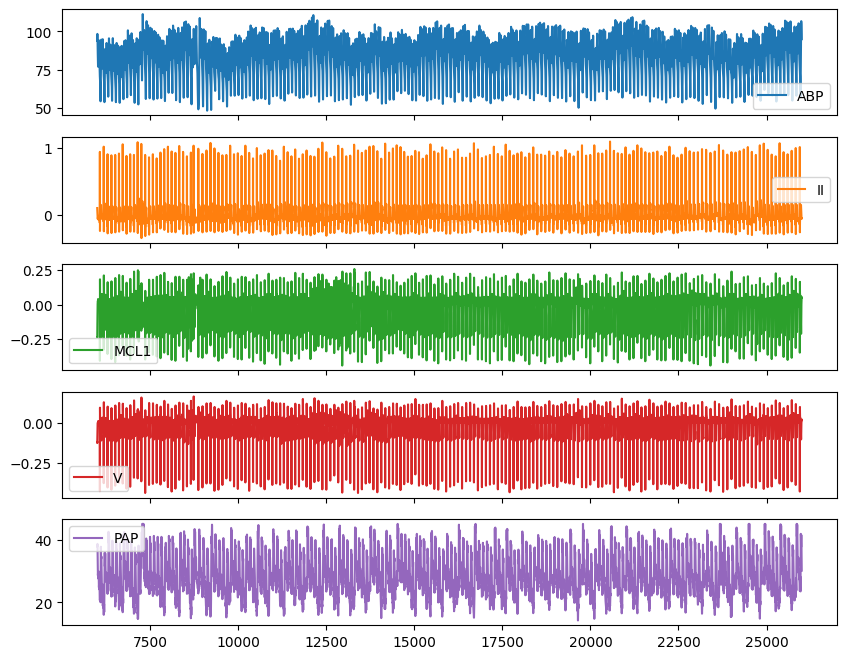

In [9]:
df_input.plot(subplots=True)

In [10]:
# # Calculate the total time in seconds
# total_time_seconds = 49.8 * 3600

# # Calculate the time interval between each sample
# time_interval_seconds = total_time_seconds / len(df_input)

# # Create an array of time indices for the 10 labels
# label_indices = np.linspace(0, len(df_input) - 1, num=2, dtype=int)

# # Retrieve the corresponding time values from the array of time indices
# time_labels = [time_interval_seconds * idx for idx in label_indices]

# # Plot the graph with the x-axis in seconds
# df_input.plot(subplots=True)

# # Add the time values in seconds to the x-axis at the specified indices
# plt.xticks(label_indices, time_labels)

# # Add the x-axis label
# plt.xlabel('Time (seconds)')

# # Display the graph
# plt.show()

In [11]:
df_input.describe()

,ABP,II,MCL1,V,PAP
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,82.464232,0.003342,-0.002801,-0.004282,28.324585
std,12.807781,0.148951,0.095446,0.068049,6.646116
min,48.199052,-0.350419,-0.441728,-0.439198,14.250000
25%,74.004739,-0.059646,-0.015492,-0.001254,23.625000
50%,83.080569,-0.039143,0.025583,0.014208,27.250000
75%,92.748815,0.021435,0.050597,0.027998,33.050000
max,111.279621,1.089469,0.259238,0.167572,45.000000


# Exploratory Analysis

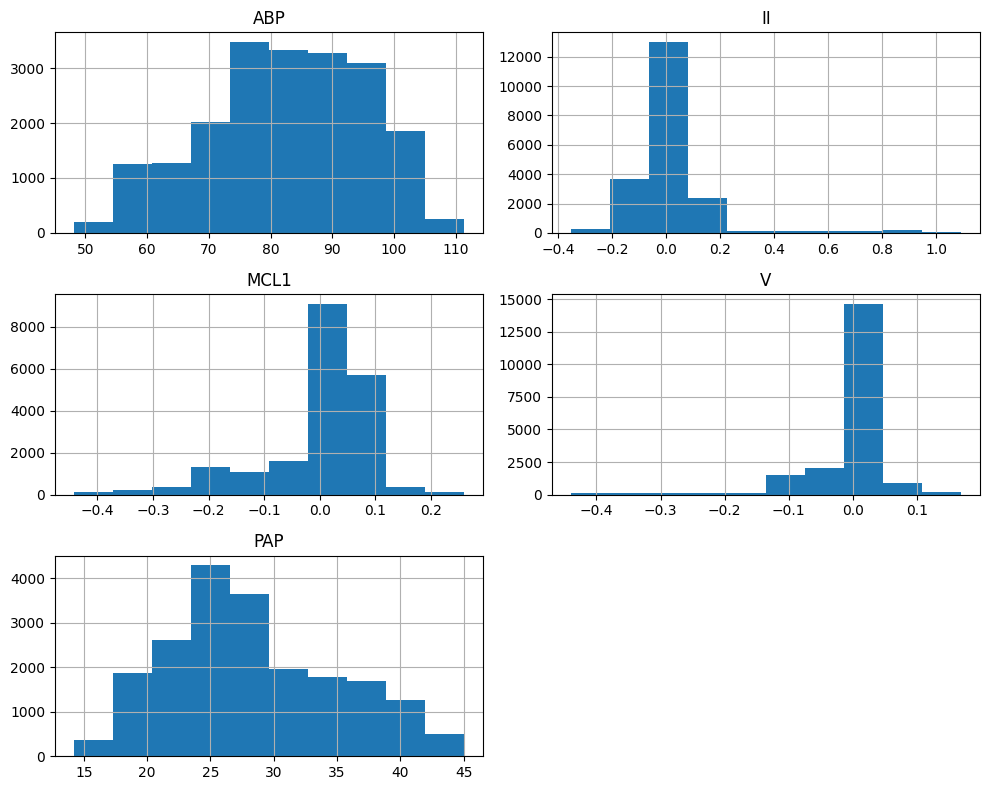

In [12]:
# Visualize the distributions of each column using histograms
df_input.hist(figsize=(10, 8))
plt.tight_layout()
plt.show()

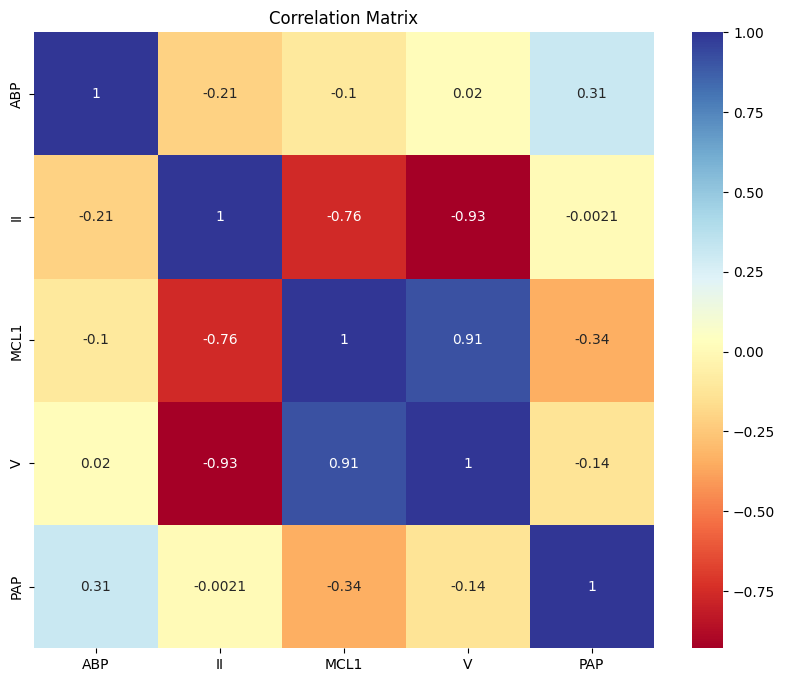

In [13]:
# Correlation Analysis
correlation_matrix = df_input.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="RdYlBu")
plt.title("Correlation Matrix")
plt.show()

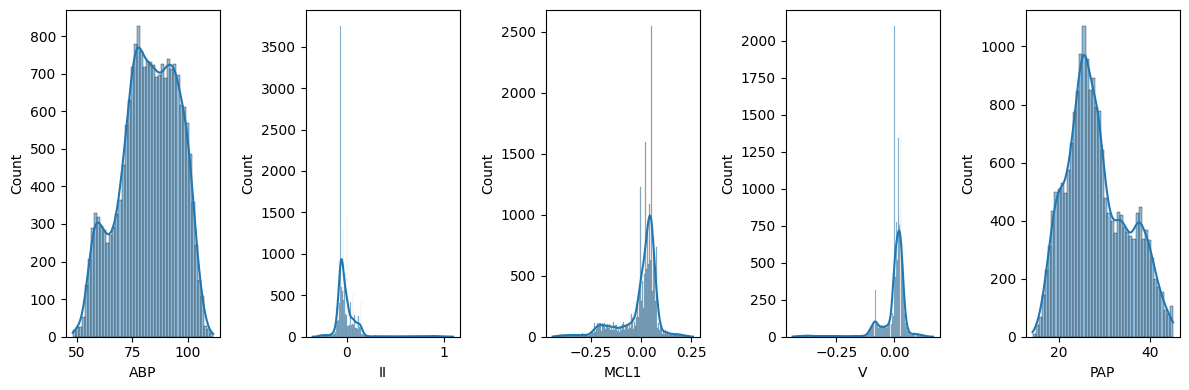

In [14]:
# Distribution Analysis
fig, axes = plt.subplots(nrows=1, ncols=len(df_input.columns), figsize=(12, 4))
for i, col in enumerate(df_input.columns):
    sns.histplot(df_input[col], ax=axes[i], kde=True)
    axes[i].set_xlabel(col)
plt.tight_layout()
plt.show()

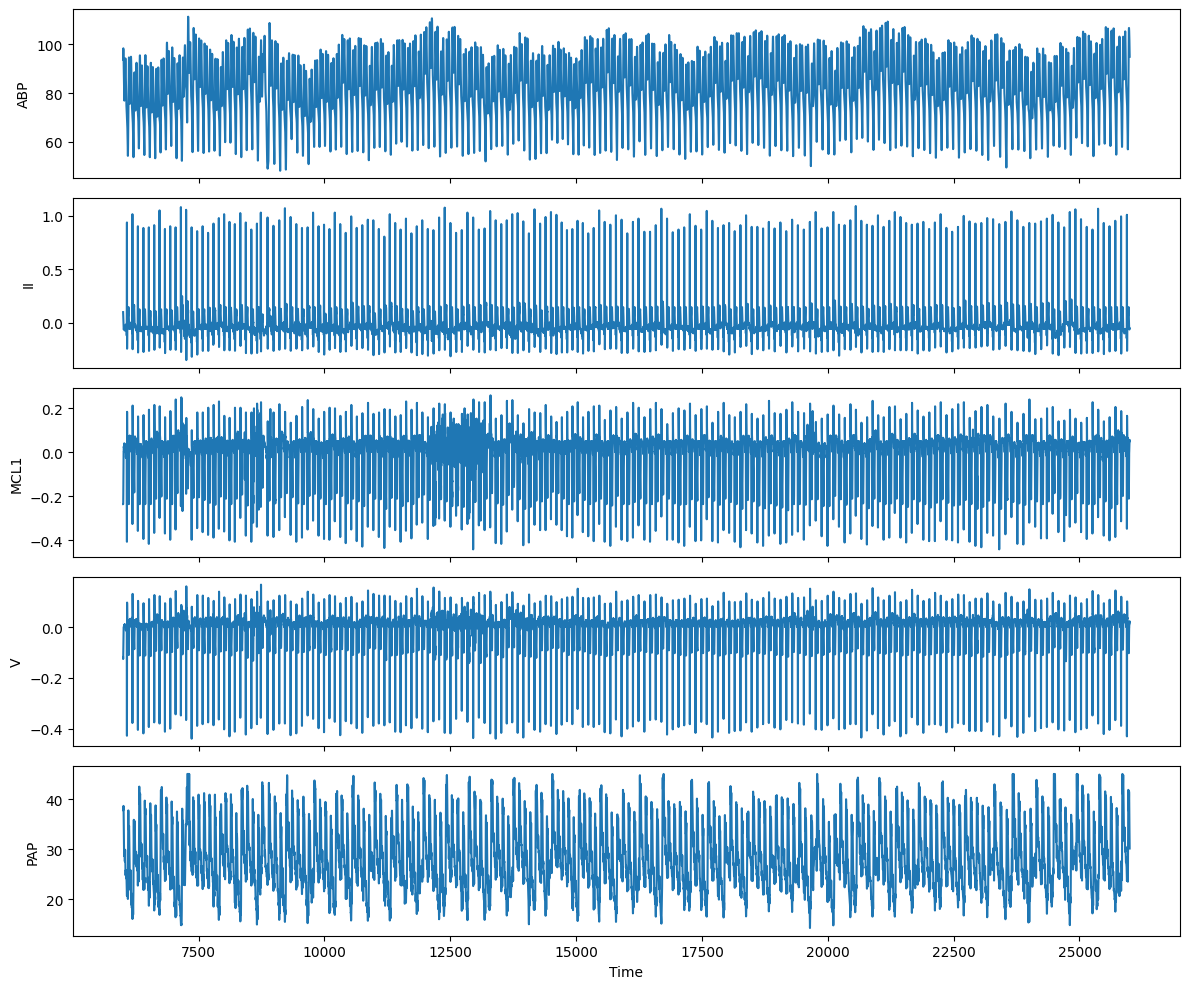

In [15]:
# Plot the time series of each variable
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 10), sharex=True)
variables = df_input.columns
for i, var in enumerate(variables):
    axes[i].plot(df_input[var])
    axes[i].set_ylabel(var)
plt.xlabel('Time')
plt.tight_layout()
plt.show()

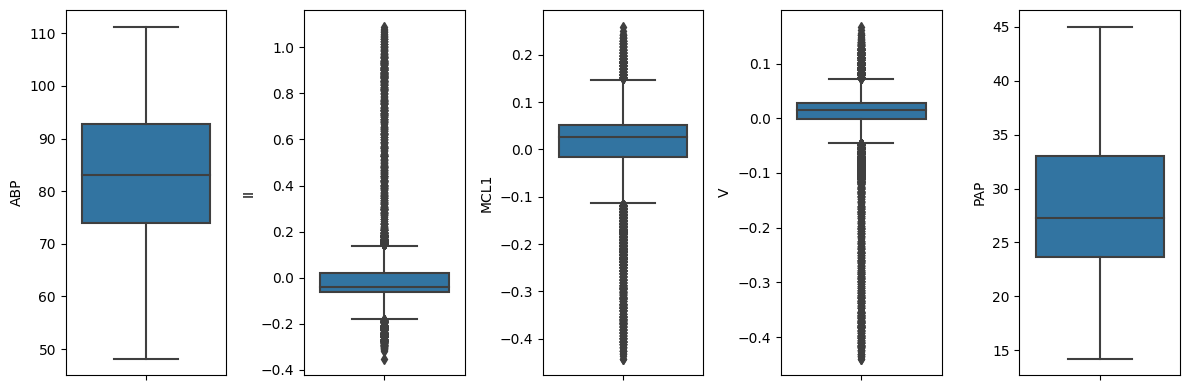

In [16]:
# Outlier Detection
fig, axes = plt.subplots(nrows=1, ncols=len(df_input.columns), figsize=(12, 4))
for i, col in enumerate(df_input.columns):
    sns.boxplot(y=df_input[col], ax=axes[i])
    axes[i].set_ylabel(col)
plt.tight_layout()
plt.show()


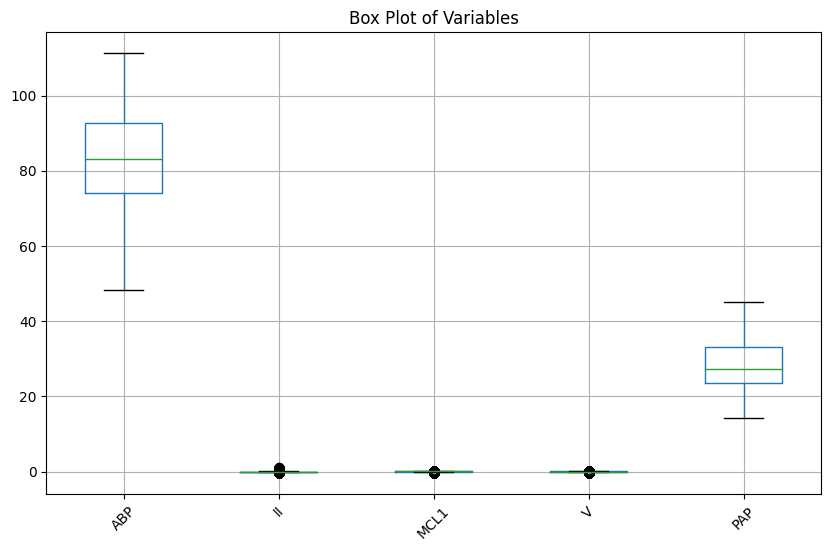

In [17]:
df_input.boxplot(figsize=(10, 6))
plt.title('Box Plot of Variables')
plt.xticks(rotation=45)
plt.show()

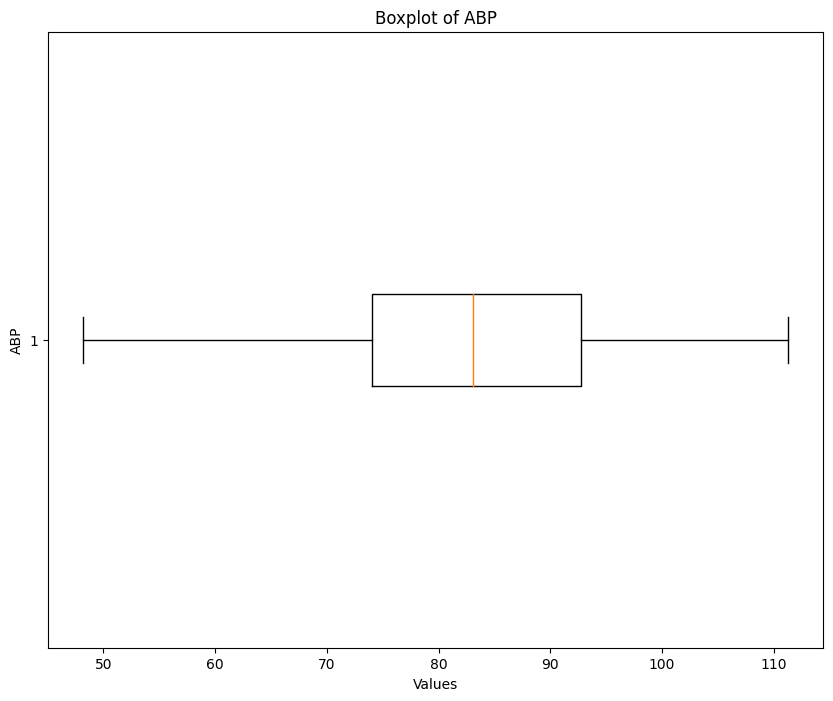

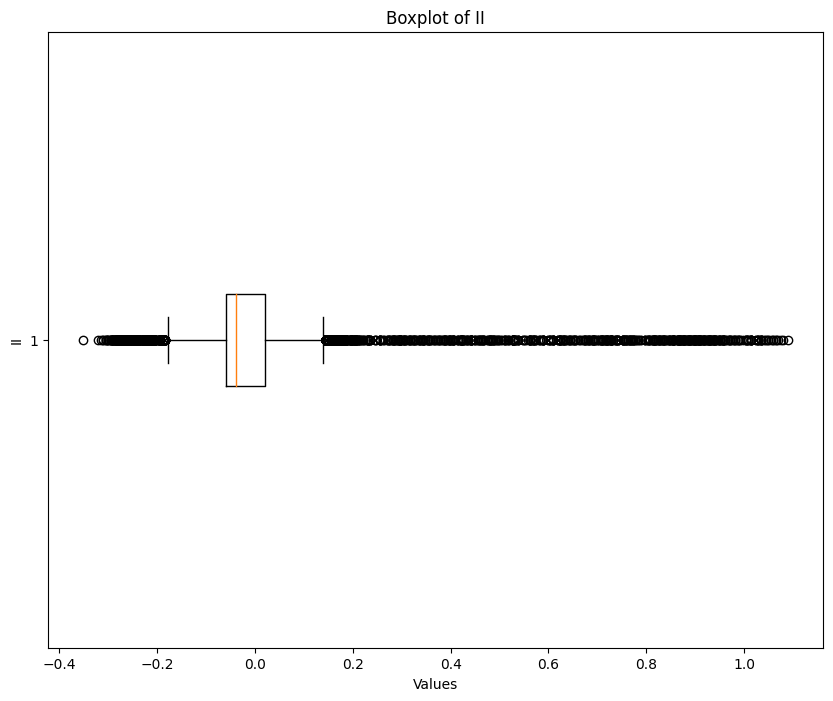

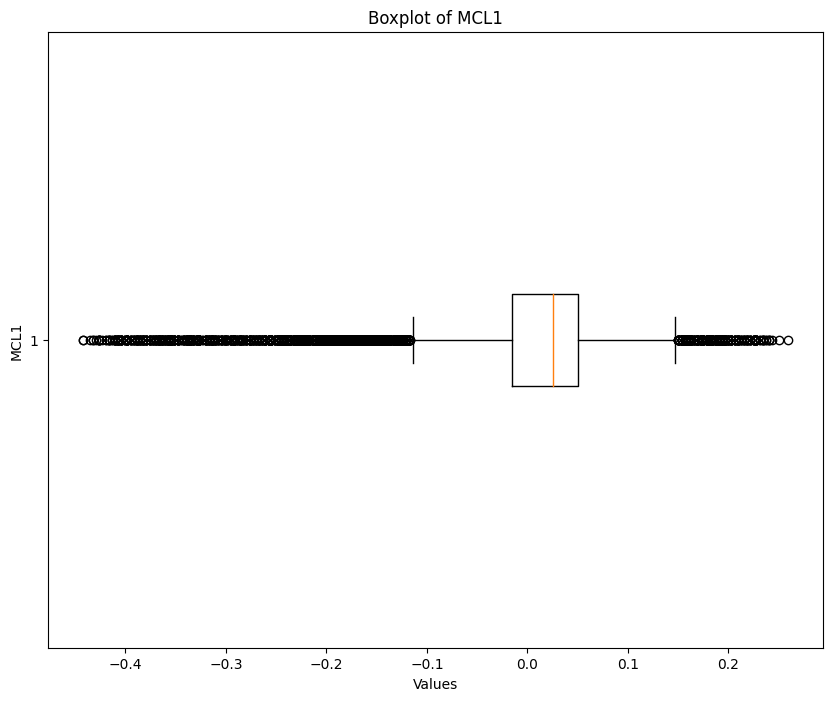

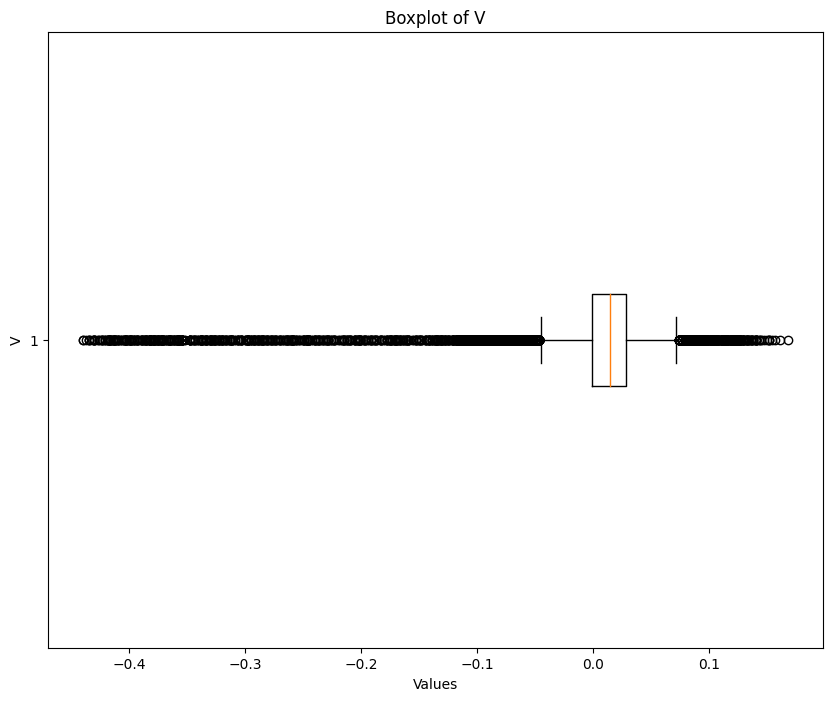

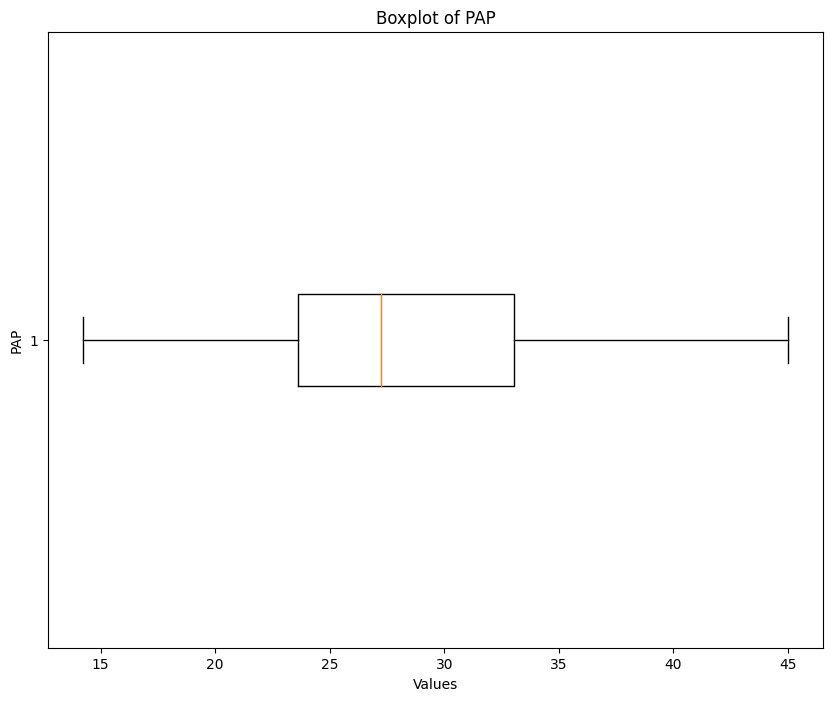

In [18]:
# Create a boxplot for each column in df_input
plt.figure(figsize=(10, 8))
for column in df_input.columns:
    plt.boxplot(df_input[column], vert=False)
    plt.title('Boxplot of ' + column)
    plt.xlabel('Values')
    plt.ylabel(column)
    plt.show()

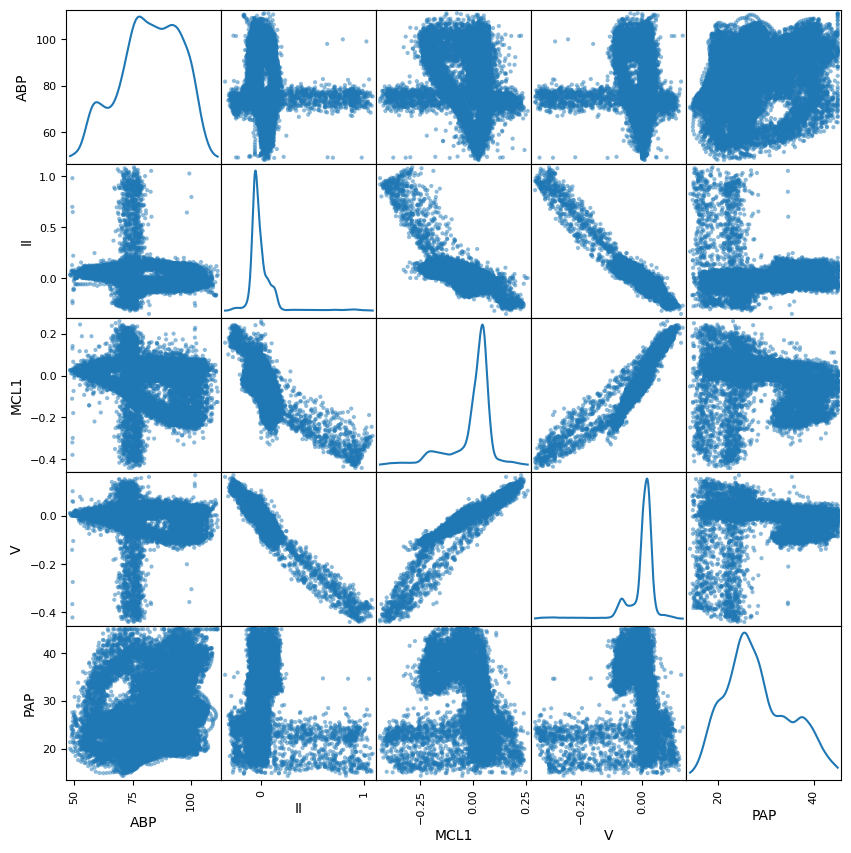

In [19]:
pd.plotting.scatter_matrix(df_input, figsize=(10, 10), diagonal='kde')
plt.show()

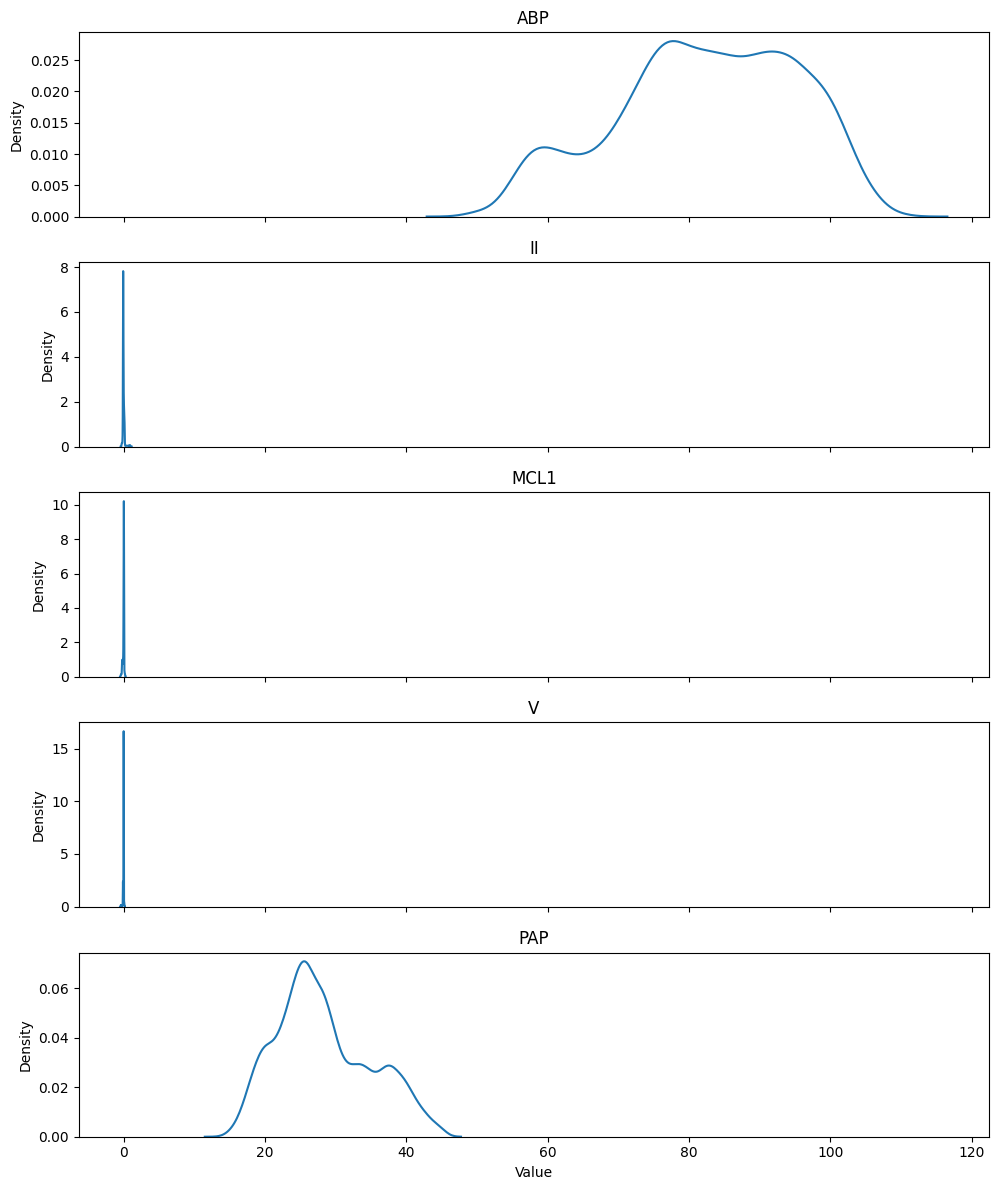

In [20]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 12), sharex=True)
variables = df_input.columns
for i, var in enumerate(variables):
    sns.kdeplot(data=df_input, x=var, ax=axes[i])
    axes[i].set_ylabel('Density')
    axes[i].set_title(var)
plt.xlabel('Value')
plt.tight_layout()
plt.show()

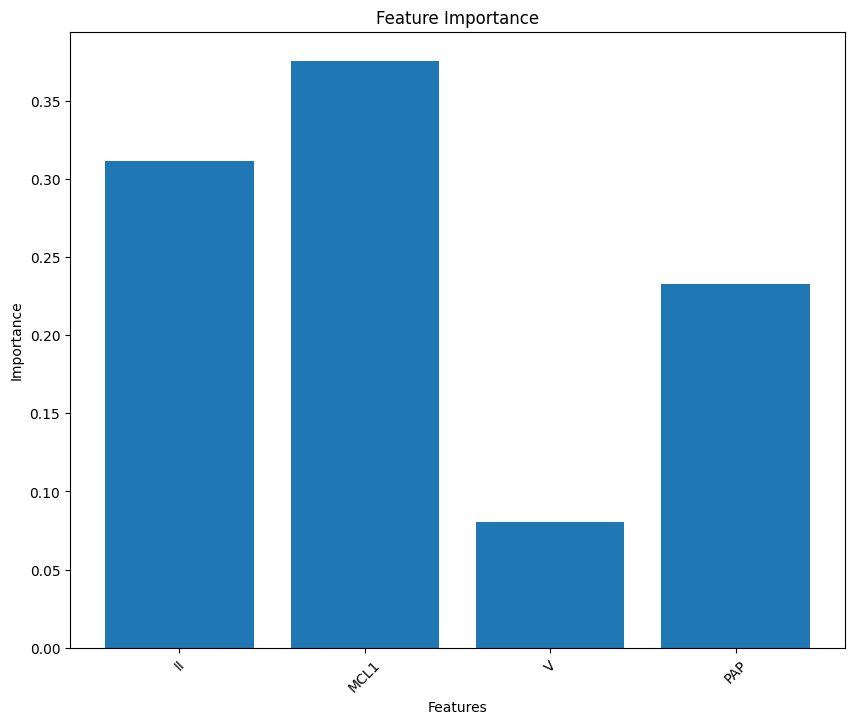

In [21]:
# Feature Importance
from sklearn.ensemble import RandomForestRegressor

features = df_input.drop('ABP', axis=1)
target = df_input['ABP']

rf = RandomForestRegressor()
rf.fit(features, target)

importance = rf.feature_importances_
plt.bar(features.columns, importance)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45)
plt.show()

# Setting the features and target, splitting, scalling and transforming the dataset

In [22]:
features = df_input.values[:,1:]
target = df_input.values[:, 0]

In [23]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.30, random_state=123, shuffle=False)

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

scaler_y = MinMaxScaler()
scaler_y.fit(y_train[:,np.newaxis])
y_train = scaler_y.transform(y_train[:,np.newaxis])[:,0]
y_test = scaler_y.transform(y_test[:,np.newaxis])[:,0]

# Creating the time-series generator object

In [24]:
win_length=25
batch_size=64
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [25]:
len(x_train), len(y_train), len(x_test), len(y_test)

(14000, 14000, 6000, 6000)

In [26]:
len(target)

20000

# Creating the model architecture and trainning

In [27]:
num_features=4

In [28]:

model = tf.keras.Sequential()
model.add(InputLayer((5, 3)))
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
#model.add(tf.keras.layers.leakyReLu(alpha=1.5))
model.add(tf.keras.layers.ReLU(1))
model.add(tf.keras.layers.LSTM(128, input_shape=(win_length, num_features), return_sequences=True))
model.add(tf.keras.layers.ReLU(1))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(128, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1))

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 128)            67584     
                                                                 
 re_lu (ReLU)                (None, 5, 128)            0         
                                                                 
 lstm_1 (LSTM)               (None, 5, 128)            131584    
                                                                 
 re_lu_1 (ReLU)              (None, 5, 128)            0         
                                                                 
 dropout (Dropout)           (None, 5, 128)            0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [30]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5,
                                                  mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanSquaredError()])

history = model.fit_generator(train_generator, epochs=10,
                              validation_data=test_generator,
                              shuffle=False,
                              callbacks=[early_stopping])

Epoch 1/10


<ipython-input-30-882c97390861>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=10,


219/219 [==============================] - 13s 20ms/step - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0322 - val_mean_squared_error: 0.0322
Epoch 2/10
219/219 [==============================] - 3s 12ms/step - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.0220 - val_mean_squared_error: 0.0220
Epoch 3/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0147 - mean_squared_error: 0.0147 - val_loss: 0.0118 - val_mean_squared_error: 0.0118
Epoch 4/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0128 - mean_squared_error: 0.0128 - val_loss: 0.0124 - val_mean_squared_error: 0.0124
Epoch 5/10
219/219 [==============================] - 2s 11ms/step - loss: 0.0130 - mean_squared_error: 0.0130 - val_loss: 0.0105 - val_mean_squared_error: 0.0105
Epoch 6/10
219/219 [==============================] - 5s 22ms/step - loss: 0.0145 - mean_squared_error: 0.0145 - val_loss: 0.0171 - val_mean_squared_error: 0.0171
Epoch 7/10
219/219 [============

# Evaluating the model

In [31]:
# Evaluate on Validation data
scores = model.evaluate(test_generator)
print("%s%s: %.2f%%" % ("evaluate ",model.metrics_names[1], scores[1]*100))
print("--")
scores = model.evaluate_generator(test_generator)
print("%s%s: %.2f%%" % ("evaluate_generator ",model.metrics_names[1], scores[1]*100))

94/94 [==============================] - 1s 7ms/step - loss: 0.0118 - mean_squared_error: 0.0118
evaluate mean_squared_error: 1.18%
--


<ipython-input-31-1324a56590e8>:5: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  scores = model.evaluate_generator(test_generator)


evaluate_generator mean_squared_error: 1.19%


In [32]:
len(model.predict(test_generator))

94/94 [==============================] - 2s 4ms/step


5975

In [33]:
predictions = scaler_y.inverse_transform(model.predict_generator(test_generator))[:,0]
#predictions = model.predict_generator(test_generator)[:,0]

<ipython-input-33-9c550a616118>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = scaler_y.inverse_transform(model.predict_generator(test_generator))[:,0]


# Make a predictions of ABP, versus ground truth

Text(0, 0, 'evaluate_generator mean_squared_error: 1.19%')

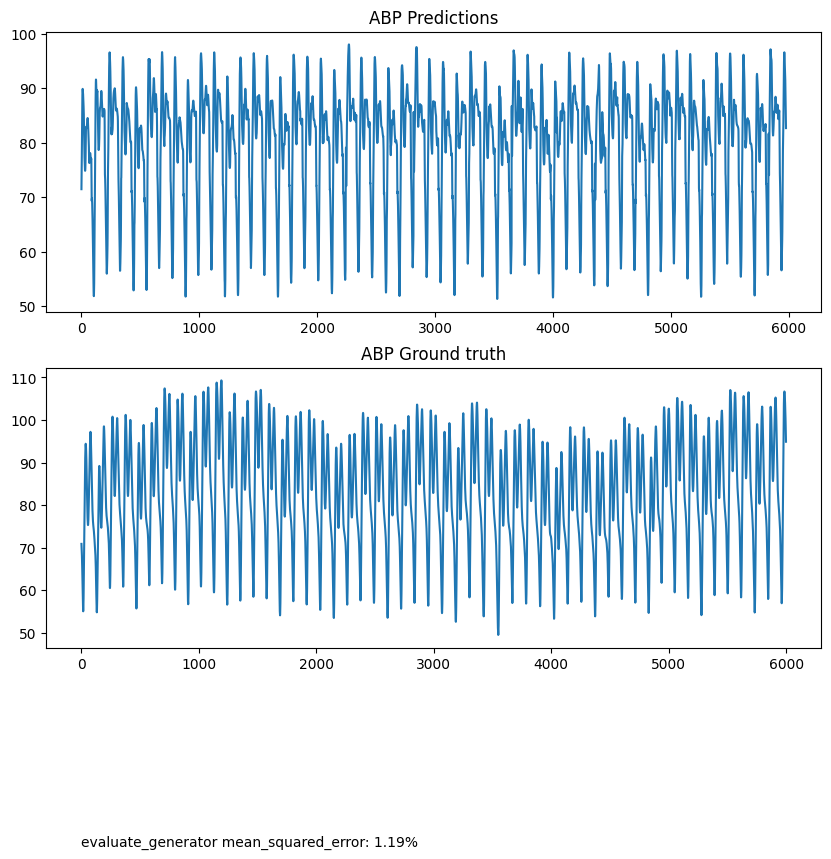

In [34]:
fig = plt.figure()

rows = 2
columns = 1

fig.add_subplot(rows, columns, 1)

plt.plot(predictions)
plt.axis('on')
plt.title("ABP Predictions")

fig.add_subplot(rows, columns, 2)

#plt.plot(df_input['ABPs [mmHg]'][::][:4000])
#plt.plot(df_input['ABPs [mmHg]'][::][10000:])
ground_truth = scaler_y.inverse_transform(y_test[:, np.newaxis])[:,0]
plt.plot(ground_truth)
plt.axis('on')
plt.title("ABP Ground truth")

plt.text(0, 0, "%s%s: %.2f%%" % ("evaluate_generator ",model.metrics_names[1], scores[1]*100))

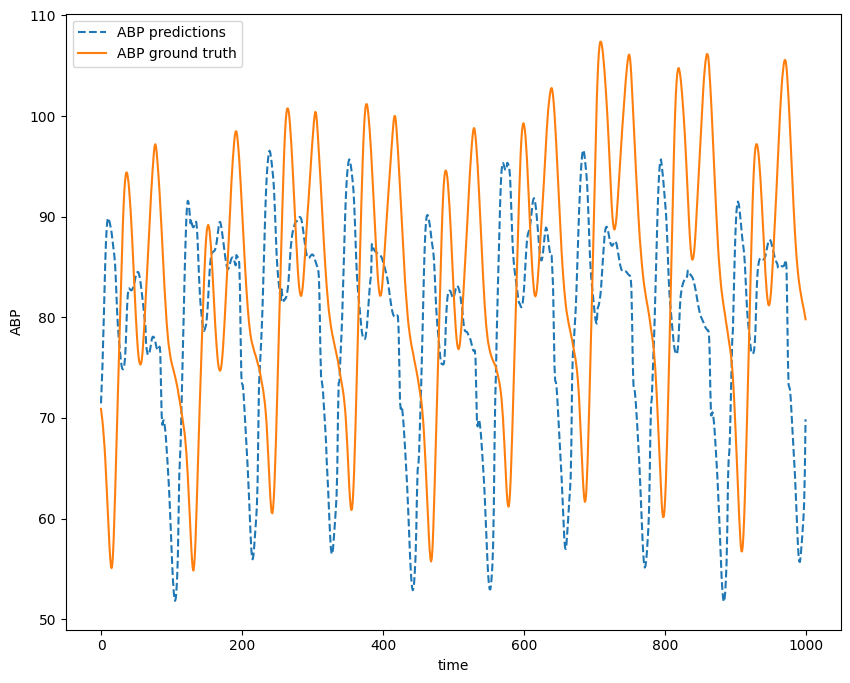

In [35]:
plt.plot(predictions[:1000], label='ABP predictions', linestyle="dashed")
plt.plot(ground_truth[:1000], label='ABP ground truth')
plt.xlabel("time")
plt.ylabel("ABP")
plt.legend()
plt.show()

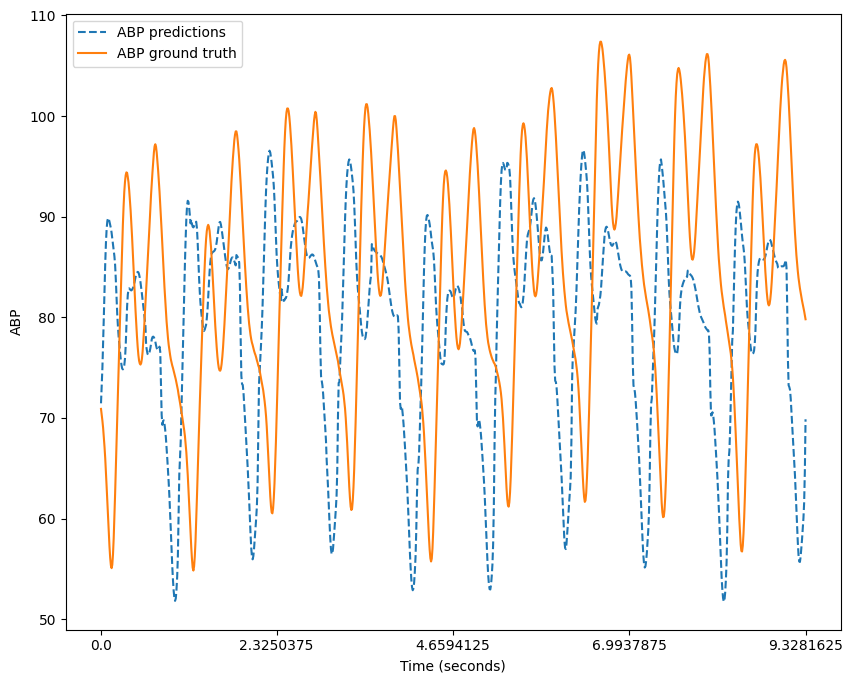

In [88]:
# Calculate the total time in seconds
total_time_seconds = 49.8 * 3600

# Calculate the time interval between each sample
time_interval_seconds = total_time_seconds / 19200000

# Create an array of time indices for the 10 labels
label_indices = np.linspace(0, 999, num=5, dtype=int)

# Retrieve the corresponding time values from the array of time indices
time_labels = [time_interval_seconds * idx for idx in label_indices]

# Plot the predictions and ground truth with the x-axis as time in seconds
plt.plot(predictions[:1000], label='ABP predictions', linestyle="dashed")
plt.plot(ground_truth[:1000], label='ABP ground truth')

# Add the time values in seconds to the x-axis at the specified indices
plt.xticks(label_indices, time_labels)

# Add x-axis and y-axis labels
plt.xlabel("Time (seconds)")
plt.ylabel("ABP")

# Add the legend
plt.legend()

# Display the plot
plt.show()

In [37]:
predictions

array([71.455025, 73.12052 , 75.01581 , ..., 84.34875 , 83.397835,
       82.67097 ], dtype=float32)

In [38]:
ground_truth

array([70.90047393, 70.33175355, 69.71563981, ..., 97.72511848,
       96.3507109 , 94.88151659])

Text(0, 0, 'evaluate_generator mean_squared_error: 1.19%')

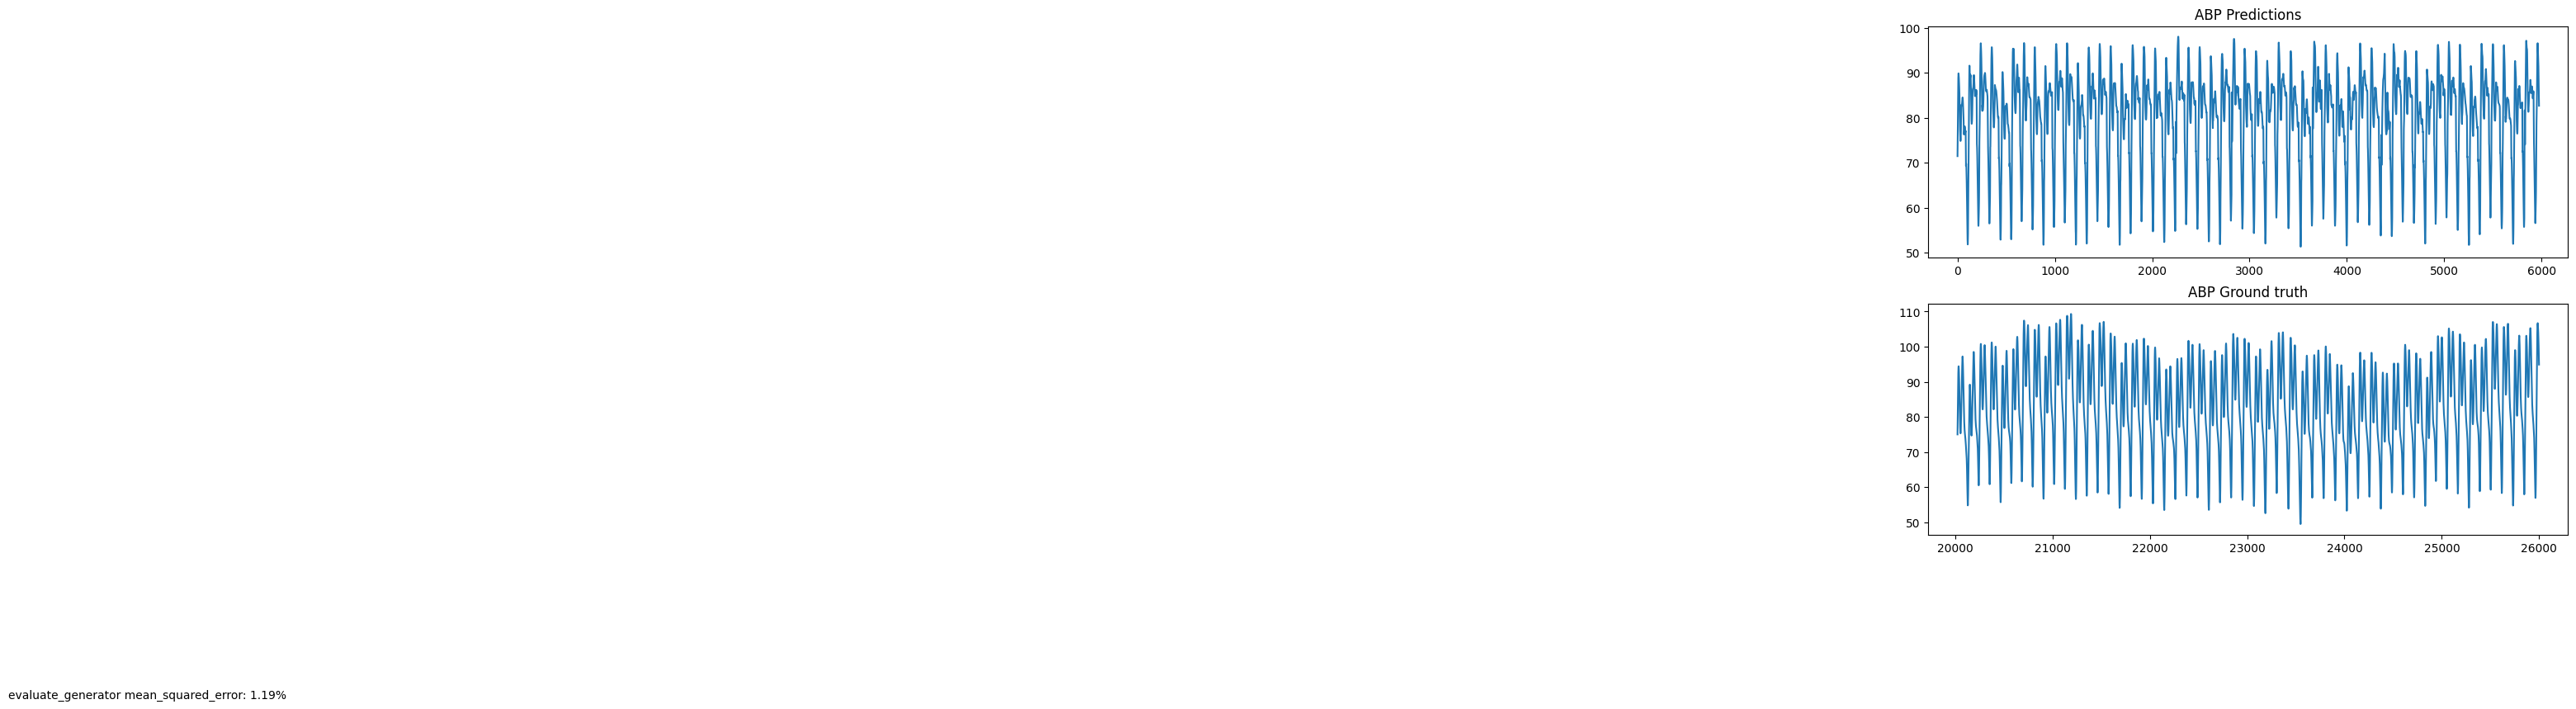

In [39]:
fig = plt.figure()

rows = 2
columns = 1

fig.add_subplot(rows, columns, 1)

plt.plot(predictions)
plt.axis('on')
plt.title("ABP Predictions")

fig.add_subplot(rows, columns, 2)

# Adjust the start index to align the data
start_index = len(df_input) - len(predictions)

plt.plot(df_input['ABP'][start_index:])
plt.axis('on')
plt.title("ABP Ground truth")

plt.text(0, 0, "%s%s: %.2f%%" % ("evaluate_generator ", model.metrics_names[1], scores[1]*100))


Text(0, 0, 'evaluate_generator mean_squared_error: 1.19%')

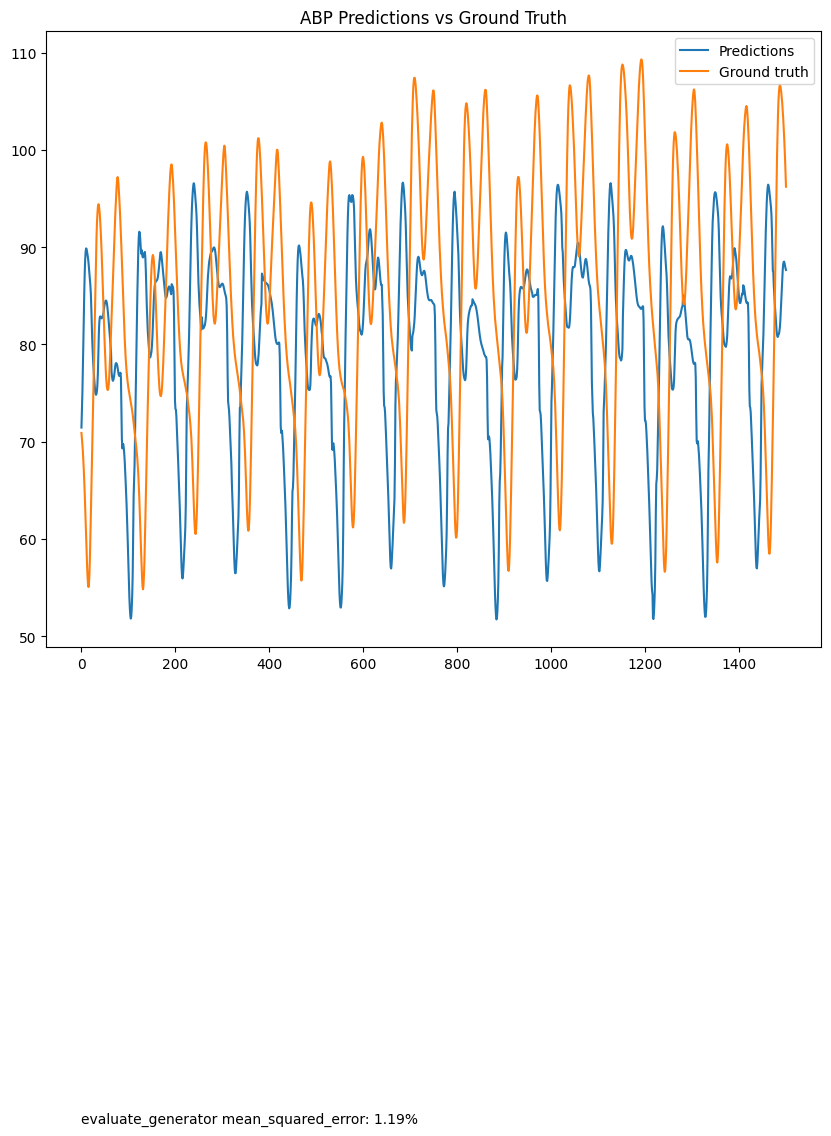

In [40]:
fig = plt.figure()

rows = 1
columns = 1

fig.add_subplot(rows, columns, 1)

plt.plot(predictions[0:1500], label='Predictions')
plt.plot(ground_truth[0:1500], label='Ground truth')
plt.legend()
plt.axis('on')
plt.title("ABP Predictions vs Ground Truth")

plt.text(0, 0, "%s%s: %.2f%%" % ("evaluate_generator ", model.metrics_names[1], scores[1]*100))


In [41]:
# Convert predictions and ground truth to numpy arrays
predictions = np.array(predictions)
predictions = predictions[0:5975]
ground_truth = np.array(ground_truth)
ground_truth = ground_truth[0:5975]

In [42]:
# Calculate the absolute difference between predictions and ground truth
abs_diff = np.abs(predictions - ground_truth)


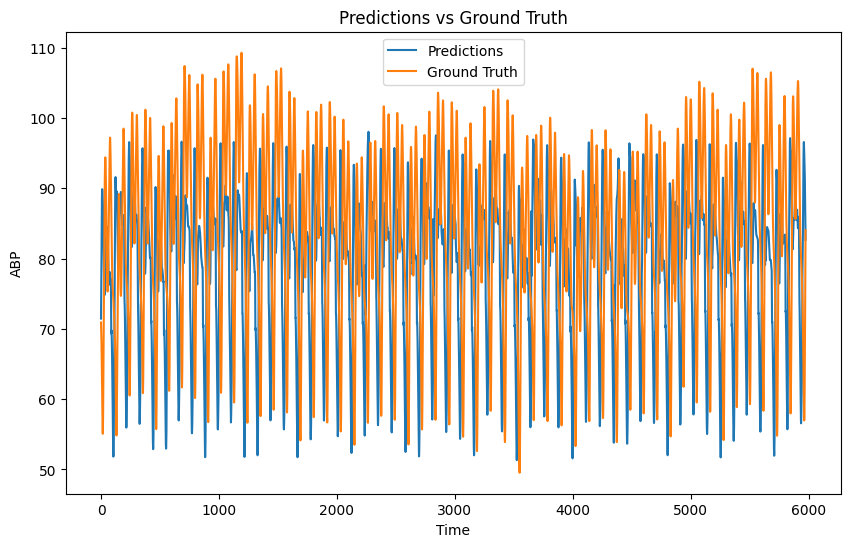

In [43]:
# Plot the predictions and ground truth values
plt.figure(figsize=(10, 6))
plt.plot(predictions, label='Predictions')
plt.plot(ground_truth, label='Ground Truth')
plt.xlabel('Time')
plt.ylabel('ABP')
plt.title('Predictions vs Ground Truth')
plt.legend()
plt.show()

In [44]:
# Calculate evaluation metrics
mse = np.mean((predictions - ground_truth) ** 2)
mae = np.mean(abs_diff)
rmse = np.sqrt(mse)
mape = np.mean(abs_diff / ground_truth) * 100

print('Mean Squared Error (MSE):', mse)
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)
print('Mean Absolute Percentage Error (MAPE):', mape)

Mean Squared Error (MSE): 313.6454339115295
Mean Absolute Error (MAE): 14.922713468295537
Root Mean Squared Error (RMSE): 17.710037659799866
Mean Absolute Percentage Error (MAPE): 19.359126823545637


# Plotting the model history

In [45]:
print(history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


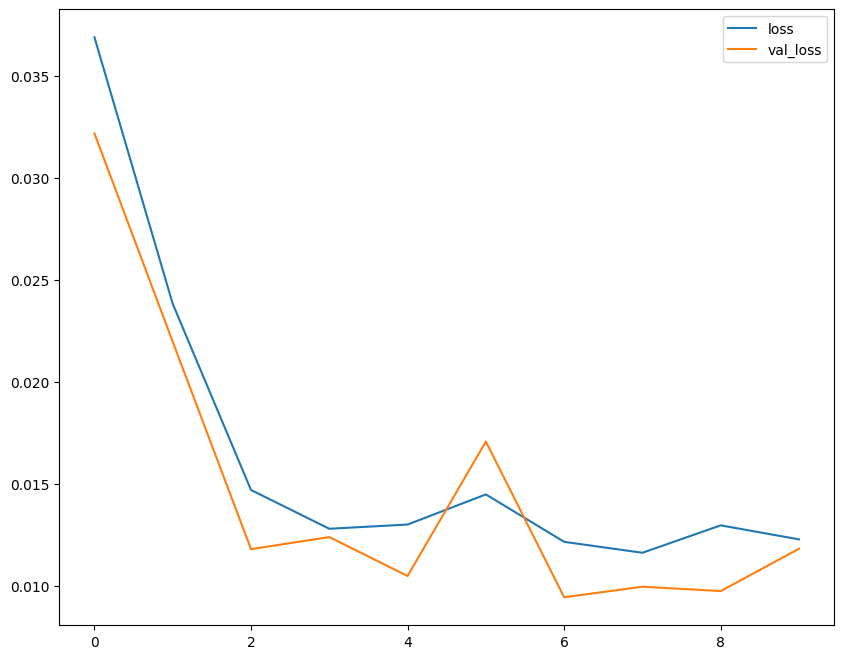

In [46]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

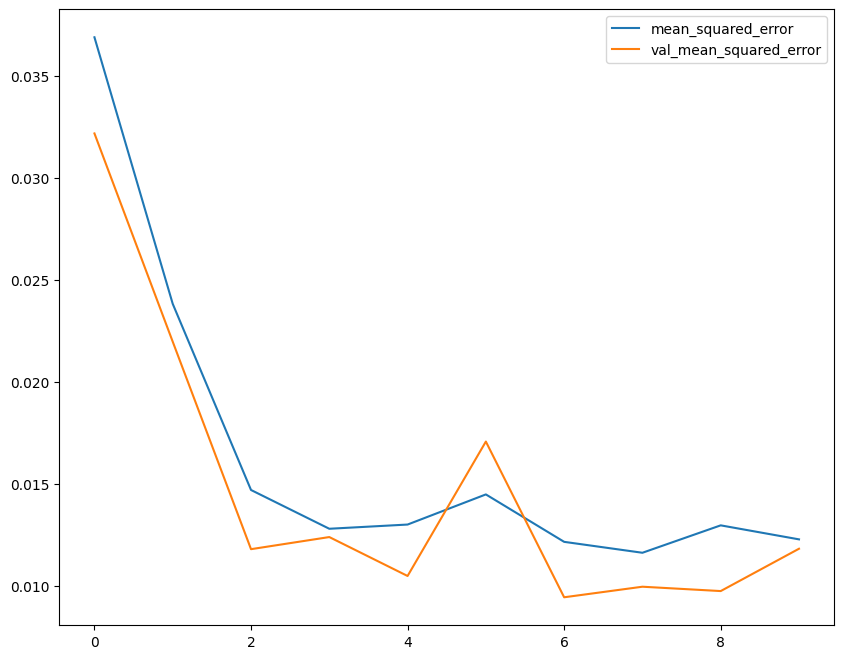

In [47]:
plt.plot(history.history['mean_squared_error'], label='mean_squared_error')
plt.plot(history.history['val_mean_squared_error'], label='val_mean_squared_error')
plt.legend()
plt.show()

# Plotting the correlation matrix

In [48]:
corr_matrix = df_input.corr()

<Axes: >

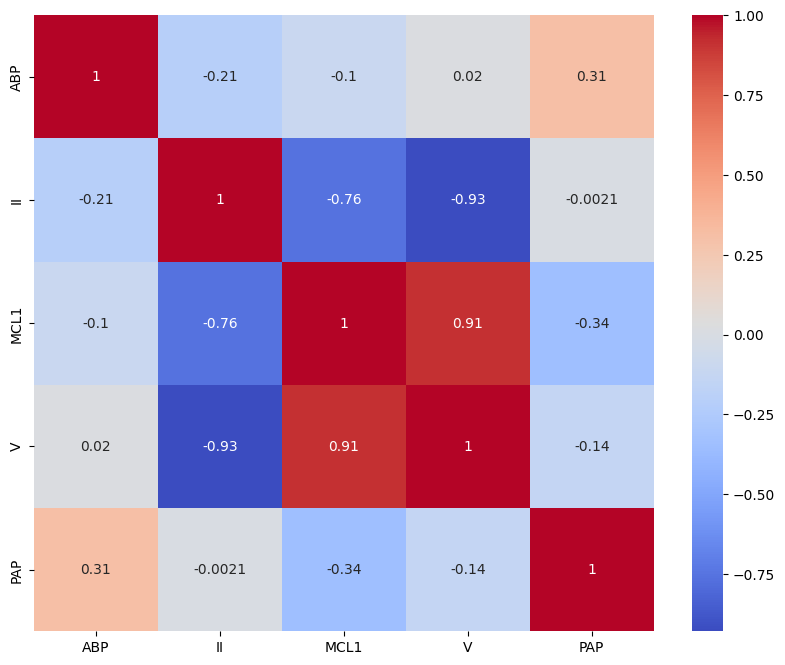

In [49]:
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True)

# Creating a heatmap from test_generator time-series

<Axes: >

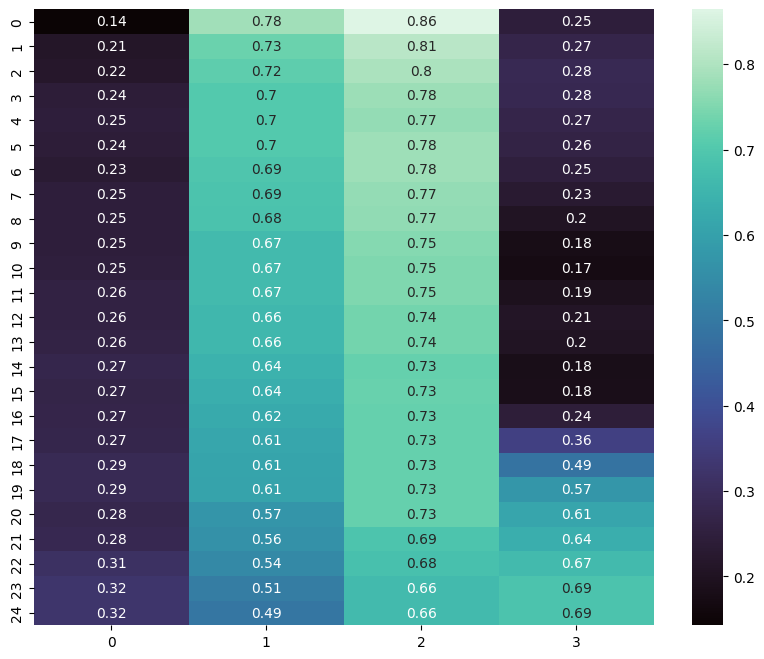

In [50]:
sns.heatmap(test_generator[0][0][0],  cmap="mako", annot=True)

<Axes: >

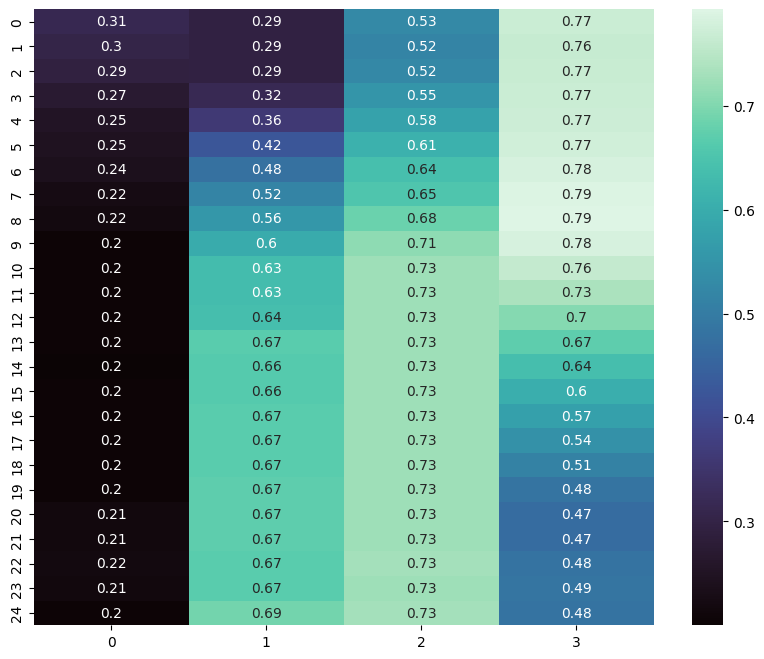

In [51]:
sns.heatmap(train_generator[0][0][0],  cmap="mako", annot=True)

# Plotting the feature importance

In [52]:
import numpy as np
from sklearn.linear_model import Ridge

# Subset of training data to compute feature importance
subset_size = 1000
subset_indices = np.random.choice(len(x_train), subset_size, replace=False)
subset = x_train[subset_indices]

# Fit a Ridge regression model to the subset data
ridge = Ridge(alpha=0.1)
ridge.fit(subset, y_train[subset_indices])

# Compute feature importance based on Ridge coefficients
feature_importance = np.abs(ridge.coef_)

# Sort features by importance in descending order
sorted_indices = np.argsort(feature_importance)[::-1]

# Print the feature importance ranking
for i in sorted_indices:
    print(f"Feature {i}: Importance {feature_importance[i]}")


Feature 0: Importance 2.2587917588435653
Feature 2: Importance 1.93125346143251
Feature 3: Importance 0.1604222314948943
Feature 1: Importance 0.14248513044093106


In [53]:
df_input.columns

Index(['ABP', 'II', 'MCL1', 'V', 'PAP'], dtype='object')

In [54]:
df_input.shape

(20000, 5)

In [55]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
import pandas as pd
import matplotlib.pyplot as plt

In [56]:
from sklearn.decomposition import PCA

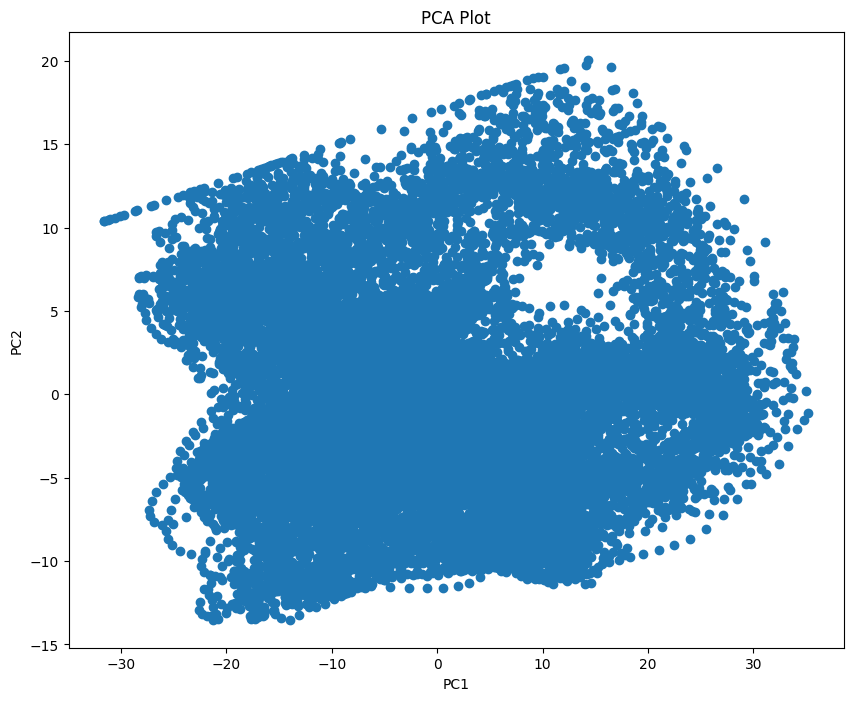

In [57]:
# Apply PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_input)

# Create a scatter plot of the PCA components
plt.scatter(df_pca[:, 0], df_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot')
plt.show()

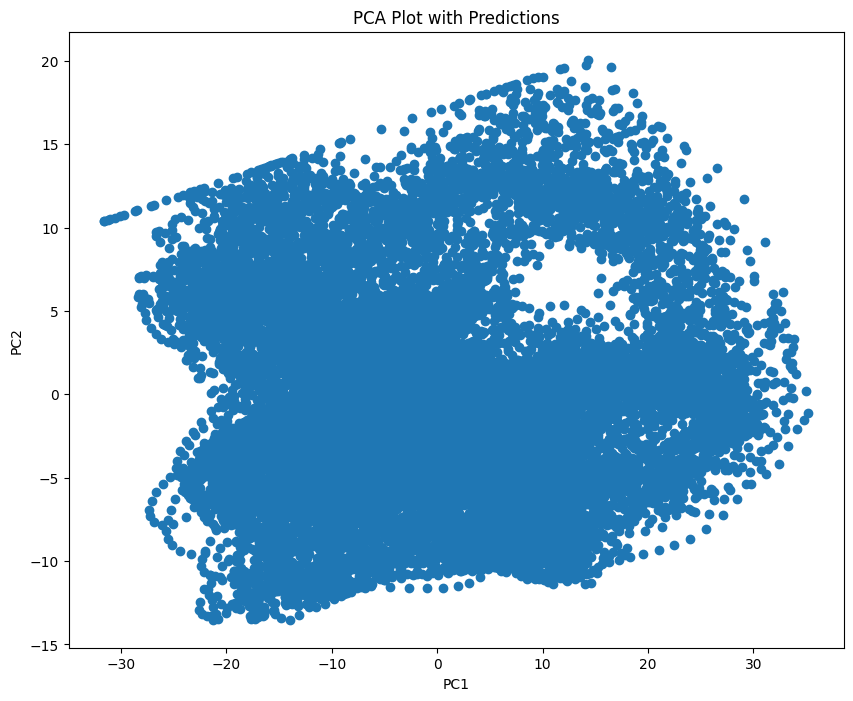

In [58]:
# Combine input data with predictions
df_combined = pd.concat([df_input, pd.Series(predictions, name='Predictions')], axis=1)

# Handle missing values by imputing with mean
imputer = SimpleImputer(strategy='mean')
df_combined_imputed = pd.DataFrame(imputer.fit_transform(df_combined), columns=df_combined.columns)

# Apply PCA
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_combined_imputed)

# Create a scatter plot of the PCA components
plt.scatter(df_pca[:, 0], df_pca[:, 1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Plot with Predictions')
plt.show()

PCA Components:
[[ 0.24036216 -0.97068328]
 [-0.97068328 -0.24036216]]

Explained Variance Ratio:
[0.6087553 0.3912447]


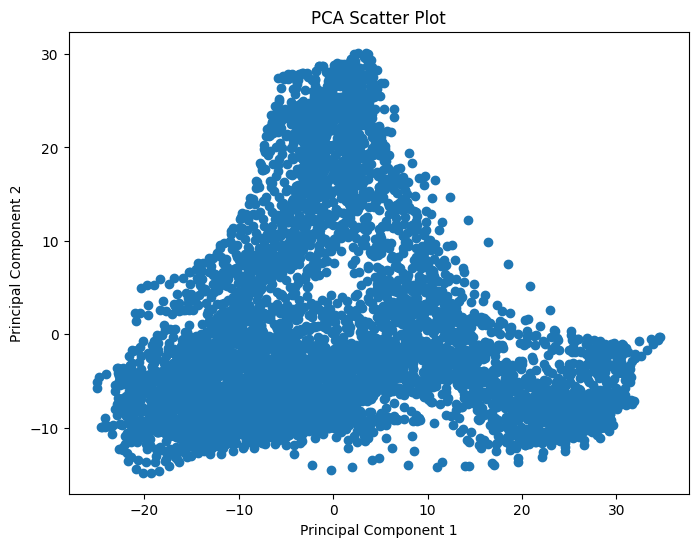

In [59]:
# Concatenate predictions and ground truth arrays
combined_data = np.concatenate((predictions[:, np.newaxis], ground_truth[:, np.newaxis]), axis=1)


# Perform PCA on the combined data
pca = PCA(n_components=2)
pca_result = pca.fit_transform(combined_data)


# Extract the PCA components
pca_components = pca.components_

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Print the PCA components and explained variance ratio
print("PCA Components:")
print(pca_components)
print()
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Plot the PCA components
plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()

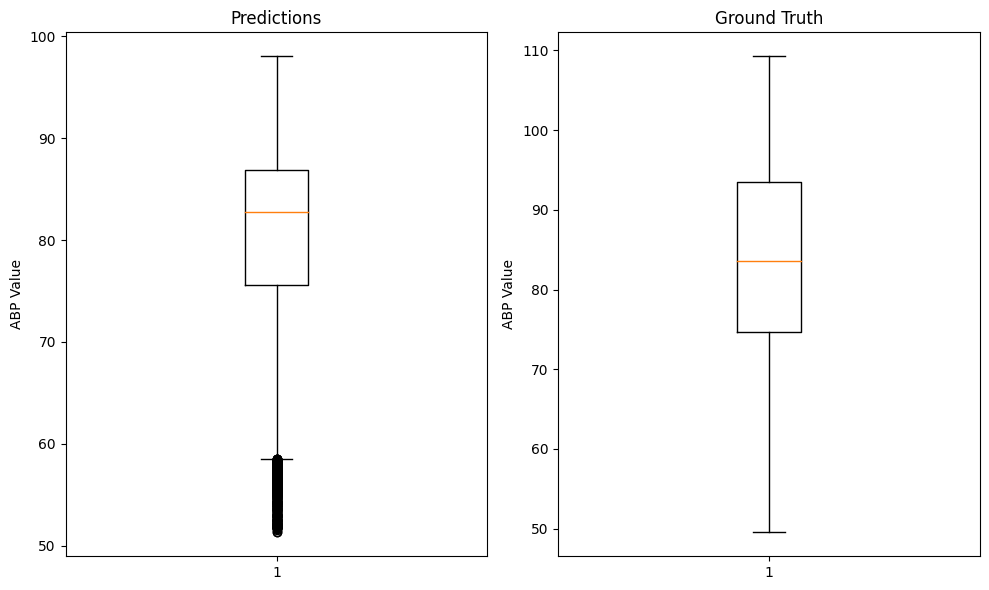

In [60]:
import matplotlib.pyplot as plt

# Plot the predictions and ground truth values with boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# Boxplot for predictions
axes[0].boxplot(predictions)
axes[0].set_title("Predictions")
axes[0].set_ylabel("ABP Value")

# Boxplot for ground truth
axes[1].boxplot(ground_truth)
axes[1].set_title("Ground Truth")
axes[1].set_ylabel("ABP Value")

plt.tight_layout()
plt.show()


In [61]:
# Get the predictions for the corresponding subset of data
predictions = scaler_y.inverse_transform(model.predict_generator(test_generator))[:, 0]
predictions = predictions[:20000]  # Adjust the range based on the subset of data used


<ipython-input-61-24d2939b76e9>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = scaler_y.inverse_transform(model.predict_generator(test_generator))[:, 0]


In [62]:
predictions.shape

(5975,)

In [63]:
ground_truth.shape

(5975,)

In [64]:
ground_truth = ground_truth[0:5975]

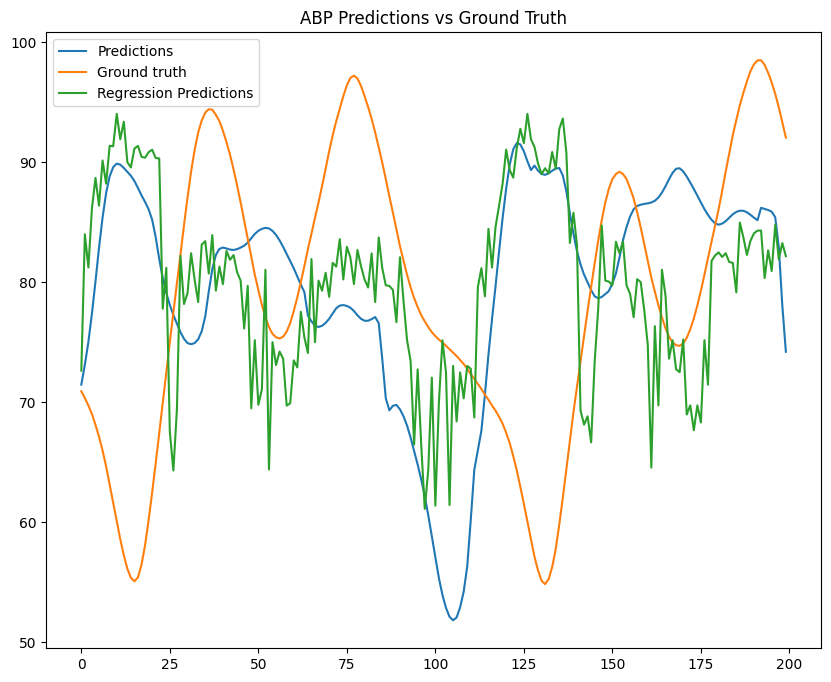

In [65]:
from sklearn.tree import DecisionTreeRegressor

# Create and train the decision tree regressor
regressor = DecisionTreeRegressor()
regressor.fit(ground_truth.reshape(-1, 1), predictions.reshape(-1, 1))

# Make predictions using the trained regressor
predictions_regressor = regressor.predict(ground_truth.reshape(-1, 1))

# Plot the predictions and ground truth values
fig = plt.figure()

rows = 1
columns = 1

fig.add_subplot(rows, columns, 1)

plt.plot(predictions[0:200], label='Predictions')
plt.plot(ground_truth[0:200], label='Ground truth')
plt.plot(predictions_regressor[0:200], label='Regression Predictions')
plt.legend()
plt.axis('on')
plt.title("ABP Predictions vs Ground Truth")

plt.show()


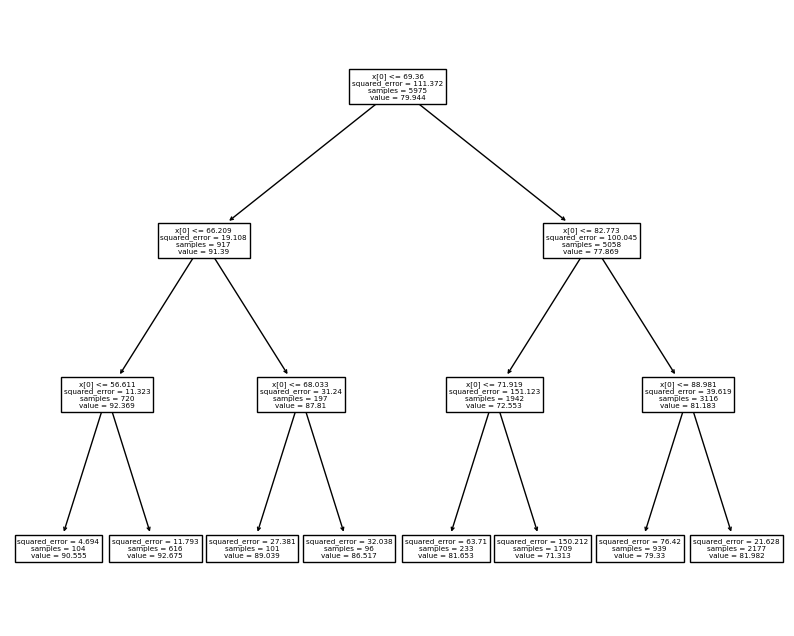

In [66]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import matplotlib.pyplot as plt

# Create and train the decision tree regressor
regressor = DecisionTreeRegressor(max_depth=3)
regressor.fit(ground_truth.reshape(-1, 1), predictions.reshape(-1, 1))

# Visualize the decision tree with three levels
fig = plt.figure(figsize=(10, 8))
_ = tree.plot_tree(regressor, max_depth=3)
plt.show()


# SHAP

In [67]:
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 18.6 MB/s eta 0:00:00


In [68]:
x_train.shape

(14000, 4)

In [69]:
y_train.shape

(14000,)

In [70]:
x_test.shape

(6000, 4)

In [71]:
y_test.shape

(6000,)

In [72]:
predictions.shape

(5975,)

In [73]:
ground_truth.shape

(5975,)

In [74]:
win_length = 25
num_features = 4
stride = 1

In [75]:
num_samples = len(x_test)
num_windows = (num_samples - win_length) // stride + 1


In [76]:
# Specify the number of background samples for SHAP explainer
num_background_samples = 10


In [77]:
x_train_2d = x_train.reshape(-1, num_features)


In [78]:
x_train_reshaped = np.zeros((num_windows, win_length, num_features))
for i in range(num_windows):
    x_train_reshaped[i] = x_train_2d[i:i+win_length].reshape((win_length, num_features))


In [79]:
win_length = 25
num_features = x_train.shape[1]

x_train_reshaped = x_train.reshape(-1, win_length, num_features)
x_test_reshaped = x_test.reshape(-1, win_length, num_features)


In [80]:
import shap
import numpy as np

# Reshape the input data to match the LSTM input shape
x_train_reshaped = x_train.reshape(x_train.shape[0], win_length, num_features)
x_test_reshaped = x_test.reshape(x_test.shape[0], win_length, num_features)

# Create a kernel explainer object using the trained model and the background dataset
explainer = shap.KernelExplainer(model.predict, shap.kmeans(x_train_reshaped, num_background_samples, n_init=10))

# Calculate SHAP values for the test dataset
shap_values = explainer.shap_values(x_test_reshaped)

# Plot the SHAP values
shap.summary_plot(shap_values, feature_names=X.columns)


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


ValueError: ignored

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Reshape x_train_sample to match the expected input shape
x_train_reshaped = np.reshape(x_train_sample, (-1, 5, 4))  # Reshape to (num_samples, sequence_length, num_features)

# Pad or truncate the sequences to have a fixed length of 5 and 3 features
x_train_padded = pad_sequences(x_train_reshaped, maxlen=5, padding='post', truncating='post', dtype='float32')

# Trim or pad the features to have a dimension of 3
x_train_padded = x_train_padded[:, :, :3]

# Reshape x_test to match the expected input shape
x_test_reshaped = np.reshape(x_test, (-1, 5, 4))  # Reshape to (num_samples, sequence_length, num_features)

# Pad or truncate the sequences to have a fixed length of 5 and 3 features
x_test_padded = pad_sequences(x_test_reshaped, maxlen=5, padding='post', truncating='post', dtype='float32')

# Trim or pad the features to have a dimension of 3
x_test_padded = x_test_padded[:, :, :3]

# Create a DeepExplainer object
explainer = shap.DeepExplainer(model, x_train_padded)

# Compute the SHAP values
shap_values = explainer.shap_values(x_test_padded)
